In [1]:
# Plotting and analysis
# behavior figures

# this version was built with pandas version 2.2.2 and numpy version 1.26.4
# looking at bulk tuning curves in one plot for ACx and IC

#%% file import pre procesing
import pandas as pd
import numpy as np


import math 

#plots
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter

from array import *
from scipy.signal import find_peaks

print(np.__version__)

from scipy.ndimage import median_filter

import auto_tuning_functions_current as auto_tune

1.26.4


In [19]:
def single_trial_param_var(current_df, freq_ls, db_ls, sanity='no'):
    """
    Analyzes neural firing parameters at the single trial level to measure variability.
    
    Parameters:
    current_df - DataFrame containing neural data where each row is a dB level for a particular unit
    freq_ls - List of frequency values
    db_ls - List of decibel values
    sanity - Whether to generate sanity check plots
    
    Returns:
    DataFrame containing trial-by-trial results with variability metrics
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Create a list to store all trial results
    all_trial_results = []
    
    # Loop through each unique file/channel combination (each unit)
    for file_name in current_df['file'].unique():
        file_df = current_df[current_df['file'] == file_name]
        
        for channel in file_df['channel'].unique():
            unit_df = file_df[file_df['channel'] == channel]
            
            # Get genotype
            genotype = unit_df['Genotype'].iloc[0] if 'Genotype' in unit_df.columns else 'Unknown'
            
            print(f"Processing unit: {file_name}, channel: {channel}")
            
            # Loop through each dB level (each row in the unit's data)
            for idx, row in unit_df.iterrows():
                db_index = unit_df.index.get_loc(idx)  # Get the position in the dataframe
                if db_index < len(db_ls):
                    db_level = db_ls[db_index]
                else:
                    db_level = db_index  # Fallback if db_ls doesn't match
                
                # Get spike trains for this intensity level
                spike_trains = row[0]
                
                # Check if spike_trains is a list or array of trial data
                if not isinstance(spike_trains, (list, np.ndarray)):
                    print(f"  Skipping {file_name}, channel {channel}, dB {db_level}: Invalid data type")
                    continue
                
                # If it's a numpy array but not a list of trials, skip
                if isinstance(spike_trains, np.ndarray) and not isinstance(spike_trains[0], (list, np.ndarray)):
                    print(f"  Skipping {file_name}, channel {channel}, dB {db_level}: Not a list of trials")
                    continue
                
                print(f"  Processing dB level: {db_level}, found {len(spike_trains)} trials")
                
                # Process each individual trial
                for trial_idx, trial_spikes in enumerate(spike_trains):
                    # Make sure we have a numpy array
                    trial_spikes = np.array(trial_spikes).ravel()
                    
                    # Skip if no spikes in trial
                    if len(trial_spikes) == 0:
                        continue
                    
                    # Calculate pre-stimulus statistics (from -50ms to 0ms)
                    prestim_spikes = trial_spikes[(trial_spikes >= -0.05) & (trial_spikes < 0)]
                    
                    # Create bins for prestimulus activity
                    bin_width = 0.005  # 5ms bins
                    prestim_bins = np.arange(-0.05, 0, bin_width)
                    prestim_counts = []
                    
                    for i in range(len(prestim_bins)):
                        bin_start = prestim_bins[i]
                        bin_end = bin_start + bin_width
                        count = np.sum((prestim_spikes >= bin_start) & (prestim_spikes < bin_end))
                        prestim_counts.append(count)
                    
                    # Calculate prestimulus statistics
                    if len(prestim_counts) > 0:
                        prestim_sd = np.std(prestim_counts)
                        prestim_avg = np.mean(prestim_counts)
                    else:
                        prestim_sd = 0
                        prestim_avg = 0
                    
                    prestim_sd4 = prestim_sd * 4  # Threshold for activation
                    
                    # Create histogram for entire trial
                    trial_min = min(trial_spikes) if len(trial_spikes) > 0 else -0.05
                    trial_max = max(trial_spikes) if len(trial_spikes) > 0 else 0.05
                    bin_edges = np.arange(trial_min, trial_max + bin_width, bin_width)
                    hist, edges = np.histogram(trial_spikes, bins=bin_edges)
                    
                    # Find post-stimulus peak
                    post_stim_indices = np.where(edges[:-1] >= 0)[0]
                    
                    if len(post_stim_indices) > 0 and len(hist) > 0:
                        post_stim_hist = hist[post_stim_indices]
                        if len(post_stim_hist) > 0:
                            peak_idx_rel = np.argmax(post_stim_hist)
                            peak_idx = post_stim_indices[peak_idx_rel]
                            peak_latency = edges[peak_idx]
                            peak_fr = hist[peak_idx]
                            bl_peak_fr = peak_fr - prestim_avg
                        else:
                            peak_latency = 0
                            peak_fr = 0
                            bl_peak_fr = 0
                    else:
                        peak_latency = 0
                        peak_fr = 0
                        bl_peak_fr = 0
                    
                    # Determine if the trial is evoked
                    if peak_latency > 0 and peak_fr > prestim_sd4 and prestim_sd4 > 0:
                        evoked_status = True
                        
                        # Find first bin exceeding threshold after stimulus onset
                        post_stim_thresh = np.where((edges[:-1] >= 0) & (hist > prestim_sd4))[0]
                        if len(post_stim_thresh) > 0:
                            first_bin_exceeding_threshold = edges[post_stim_thresh[0]]
                        else:
                            first_bin_exceeding_threshold = -10
                    else:
                        evoked_status = False
                        first_bin_exceeding_threshold = -10
                    
                    # Calculate response duration
                    if evoked_status and peak_idx < len(hist):
                        # Find all bins after peak that exceed threshold
                        bins_after_peak = []
                        for i in range(peak_idx, len(hist)):
                            if hist[i] >= prestim_sd4:
                                bins_after_peak.append(edges[i])
                        
                        if len(bins_after_peak) > 0:
                            duration = max(bins_after_peak) - min(bins_after_peak)
                            last_bin = max(bins_after_peak)
                        else:
                            duration = 0.005  # Minimum duration of one bin
                            last_bin = edges[peak_idx]
                    else:
                        duration = 0.005
                        last_bin = 0.02  # Default value
                    
                    duration_rounded = round(duration, 8)
                    
                    # Calculate total spike count in post-stimulus window (0-50ms)
                    post_stim_spikes = trial_spikes[(trial_spikes >= 0) & (trial_spikes <= 0.05)]
                    spike_count_0_50ms = len(post_stim_spikes)
                    
                    # Generate sanity check plot if requested
                    if sanity == 'yes':
                        plt.figure(figsize=(8, 6))
                        plt.hist(trial_spikes, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)
                        plt.axvline(x=peak_latency, color='red', linestyle='--', label=f'Peak Value: {peak_latency:.3f}')
                        plt.axhline(y=prestim_sd4, color='black', linestyle='--')
                        plt.axvspan(0, 0.1, facecolor='g', alpha=.1, zorder=-100)
                        plt.title(f"{file_name}, Ch {channel}, dB {db_level}, Trial {trial_idx+1}")
                        plt.xlabel("Time (s)")
                        plt.ylabel("Spike Count")
                        plt.legend()
                        plt.show()
                    
                    # Store results for this trial
                    all_trial_results.append({
                        'file': file_name,
                        'channel': channel,
                        'dB': db_level,
                        'Genotype': genotype,
                        'trial_num': trial_idx + 1,
                        'evoked_status': evoked_status,
                        'peak_latency': peak_latency,
                        'peak_fr': peak_fr,
                        'bl_peak_fr': bl_peak_fr,
                        'duration': duration_rounded,
                        'first_threshold_bin': first_bin_exceeding_threshold,
                        'last_threshold_bin': last_bin,
                        'spike_count_0_50ms': spike_count_0_50ms,
                        'prestim_avg': prestim_avg,
                        'prestim_sd': prestim_sd
                    })
    
    # Convert all results to a DataFrame
    result_df = pd.DataFrame(all_trial_results)
    
    # Calculate variability metrics per unit and dB level
    if len(result_df) > 0:
        # Group by unit and dB level
        variability_metrics = []
        
        for (file, channel, db_level), group in result_df.groupby(['file', 'channel', 'dB']):
            # Filter for evoked trials
            evoked_trials = group[group['evoked_status'] == True]
            total_trials = len(group)
            evoked_count = len(evoked_trials)
            
            # Calculate variability metrics
            if evoked_count >= 2:  # Need at least 2 trials to compute variability
                latency_cv = evoked_trials['peak_latency'].std() / evoked_trials['peak_latency'].mean() if evoked_trials['peak_latency'].mean() != 0 else float('nan')
                fr_cv = evoked_trials['peak_fr'].std() / evoked_trials['peak_fr'].mean() if evoked_trials['peak_fr'].mean() != 0 else float('nan')
                duration_cv = evoked_trials['duration'].std() / evoked_trials['duration'].mean() if evoked_trials['duration'].mean() != 0 else float('nan')
            else:
                latency_cv = float('nan')
                fr_cv = float('nan')
                duration_cv = float('nan')
            
            # Fano factor for spike counts (variance/mean ratio)
            spike_count_mean = group['spike_count_0_50ms'].mean()
            spike_count_var = group['spike_count_0_50ms'].var()
            fano_factor = spike_count_var / spike_count_mean if spike_count_mean > 0 else float('nan')
            
            variability_metrics.append({
                'file': file,
                'channel': channel,
                'dB': db_level,
                'Genotype': group['Genotype'].iloc[0],
                'total_trials': total_trials,
                'evoked_trials': evoked_count,
                'evoked_ratio': evoked_count / total_trials if total_trials > 0 else 0,
                'peak_latency_mean': evoked_trials['peak_latency'].mean() if evoked_count > 0 else float('nan'),
                'peak_latency_std': evoked_trials['peak_latency'].std() if evoked_count > 0 else float('nan'),
                'peak_latency_cv': latency_cv,
                'peak_fr_mean': evoked_trials['peak_fr'].mean() if evoked_count > 0 else float('nan'),
                'peak_fr_std': evoked_trials['peak_fr'].std() if evoked_count > 0 else float('nan'),
                'peak_fr_cv': fr_cv,
                'duration_mean': evoked_trials['duration'].mean() if evoked_count > 0 else float('nan'),
                'duration_std': evoked_trials['duration'].std() if evoked_count > 0 else float('nan'),
                'duration_cv': duration_cv,
                'spike_count_mean': spike_count_mean,
                'spike_count_std': group['spike_count_0_50ms'].std(),
                'fano_factor': fano_factor
            })
        
        variability_df = pd.DataFrame(variability_metrics)
        
        # Add the variability metrics to the result dictionary for return
        return {
            'trial_data': result_df,
            'variability_metrics': variability_df
        }
    
    else:
        return {
            'trial_data': pd.DataFrame(),
            'variability_metrics': pd.DataFrame()
        }



In [28]:
def grand_mean(current_df, genotypes, bin_width=0.005, pre_stim_time=-0.05, post_stim_time=0.1, plot=True):
    """
    Calculate and plot the grand mean PSTH across all units for each genotype.
    
    Parameters:
    -----------
    current_df : pandas DataFrame
        DataFrame containing spike times for each unit.
    genotypes : list
        List of genotypes to process.
    bin_width : float, optional
        Width of time bins for histogram (in seconds). Default is 0.005 (5ms).
    pre_stim_time : float, optional
        Time before stimulus onset to include (in seconds). Default is -0.05 (-50ms).
    post_stim_time : float, optional
        Time after stimulus onset to include (in seconds). Default is 0.1 (100ms).
    plot : bool, optional
        Whether to plot the grand mean PSTHs. Default is True.
        
    Returns:
    --------
    dict
        Dictionary containing the grand mean PSTH for each genotype and the time bins.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from collections import defaultdict
    
    # Define the bin edges with the specified width
    bins = np.arange(pre_stim_time, post_stim_time + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width/2  # for plotting
    
    # Dictionary to store histograms for each genotype
    genotype_histograms = {geno: [] for geno in genotypes}
    
    # Iterate through each unique file
    for file_name in current_df['file'].unique():
        file_data = current_df.loc[current_df['file'] == file_name]
        
        # Iterate through each channel
        for chan in file_data['channel'].unique():
            chan_data = file_data.loc[file_data['channel'] == chan]
            
            # Get genotype for current channel
            if 'Genotype' not in chan_data.columns:
                print(f"Warning: 'Genotype' column not found in data for file {file_name}, channel {chan}")
                continue
                
            geno = chan_data['Genotype'].iloc[0]
            
            # Check if genotype is in our list
            if geno not in genotypes:
                continue
            
            # Process spike data for each frequency column
            # We're assuming frequency columns are numeric and start from index 0
            freq_cols = [col for col in chan_data.columns if isinstance(col, int) or isinstance(col, float)]
            
            for freq_col in freq_cols:
                # Get spike times for current frequency
                try:
                    # Handle different data structures safely
                    spike_times_cell = chan_data[freq_col].iloc[0]
                    
                    # Check if it's already a flat array
                    if isinstance(spike_times_cell, (list, np.ndarray)) and not hasattr(spike_times_cell, 'shape'):
                        spike_times = np.array(spike_times_cell)
                    else:
                        # Try to flatten the data safely
                        spike_times = []
                        for trial_spikes in spike_times_cell:
                            if isinstance(trial_spikes, (list, np.ndarray)):
                                spike_times.extend(trial_spikes)
                            else:
                                spike_times.append(trial_spikes)
                        spike_times = np.array(spike_times)
                    
                    # Filter out any NaN values
                    spike_times = spike_times[~np.isnan(spike_times)]
                    
                    # Skip if no valid spike times
                    if len(spike_times) == 0:
                        continue
                        
                    # Calculate histogram for these spike times
                    hist, _ = np.histogram(spike_times, bins=bins)
                    
                    # Normalize histogram to get firing rate (spikes/sec)
                    # Divide by bin width to convert to spikes/sec, and by the number of trials
                    # Estimate number of trials from the data structure
                    try:
                        if isinstance(spike_times_cell, (list, np.ndarray)) and hasattr(spike_times_cell, '__len__'):
                            n_trials = len(spike_times_cell)
                        else:
                            n_trials = 1
                    except:
                        n_trials = 1
                    
                    firing_rate = hist / (bin_width * n_trials)
                    
                    # Add to the list for this genotype
                    genotype_histograms[geno].append(firing_rate)
                    
                except Exception as e:
                    print(f"Error processing {file_name}, channel {chan}, frequency {freq_col}: {str(e)}")
                    continue
    
    # Calculate grand mean for each genotype
    grand_means = {}
    for geno in genotypes:
        if genotype_histograms[geno]:  # Check if we have data for this genotype
            # Stack histograms and calculate mean across units
            stacked_histograms = np.vstack(genotype_histograms[geno])
            grand_means[geno] = np.mean(stacked_histograms, axis=0)
        else:
            print(f"No data found for genotype {geno}")
            grand_means[geno] = np.zeros_like(bins[:-1])
    
    # Plot grand mean PSTHs if requested
    if plot:
        plt.figure(figsize=(10, 6))
        
        for geno in genotypes:
            plt.plot(bin_centers, grand_means[geno], label=f'Genotype: {geno}')
        
        plt.axvline(x=0, color='black', linestyle='--', label='Stimulus onset')
        plt.fill_betweenx(plt.ylim(), 0, post_stim_time, alpha=0.1, color='green', label='Stimulus period')
        
        plt.xlabel('Time relative to stimulus onset (s)')
        plt.ylabel('Firing rate (spikes/s)')
        plt.title('Grand Mean PSTH by Genotype')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add a small box to zoom in on the pre-stimulus baseline if needed
        if pre_stim_time < 0:
            plt.axes([0.6, 0.25, 0.25, 0.25])  # [left, bottom, width, height]
            for geno in genotypes:
                plt.plot(bin_centers, grand_means[geno], label=geno)
            plt.xlim(pre_stim_time, 0)
            plt.title('Pre-stimulus baseline')
            plt.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()
    
    # Return the grand means and bin centers for further analysis
    return {'grand_means': grand_means, 'bin_centers': bin_centers}

def make_grand_mean_df(current_df, genotypes, bin_width=0.005, pre_stim_time=-0.05, post_stim_time=0.1):
    """
    Create a DataFrame containing the grand mean PSTH for each genotype.
    
    Parameters:
    -----------
    current_df : pandas DataFrame
        DataFrame containing spike times for each unit.
    genotypes : list
        List of genotypes to process.
    bin_width : float, optional
        Width of time bins for histogram (in seconds). Default is 0.005 (5ms).
    pre_stim_time : float, optional
        Time before stimulus onset to include (in seconds). Default is -0.05 (-50ms).
    post_stim_time : float, optional
        Time after stimulus onset to include (in seconds). Default is 0.1 (100ms).
        
    Returns:
    --------
    pandas DataFrame
        DataFrame containing the grand mean PSTH for each genotype.
    """
    result = grand_mean(current_df, genotypes, bin_width, pre_stim_time, post_stim_time, plot=False)
    
    # Convert to DataFrame
    grand_means = result['grand_means']
    bin_centers = result['bin_centers']
    
    # Create a DataFrame with bin_centers as index
    df = pd.DataFrame(index=bin_centers)
    
    # Add each genotype as a column
    for geno in genotypes:
        df[geno] = grand_means[geno]
    
    # Add time column
    df['time'] = bin_centers
    
    return df

/tmp/ipykernel_111612/1852757903.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


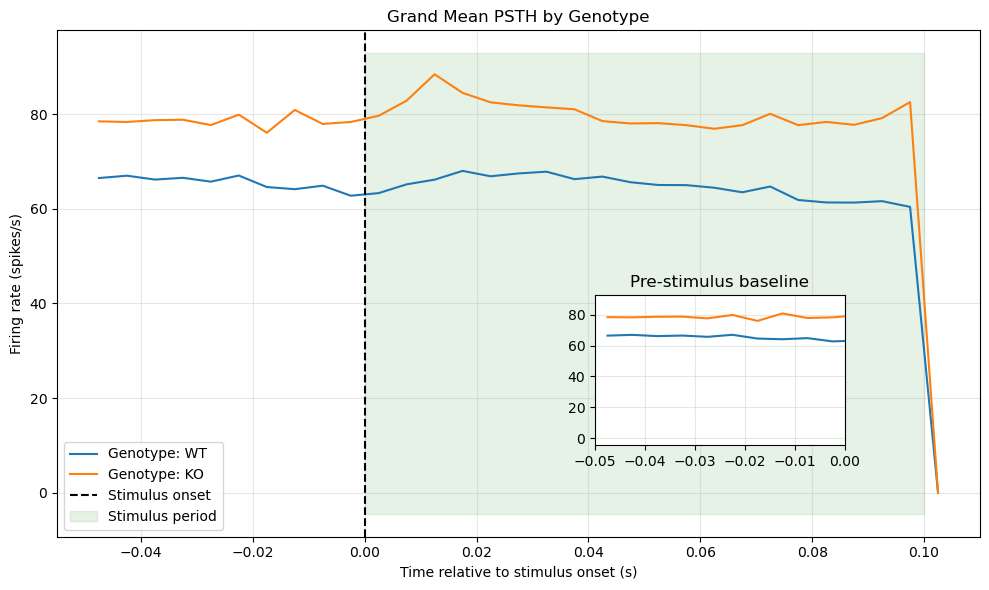

In [29]:
freq_ls = [0]
db_ls = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

mgb_spks = pd.read_pickle('mgb_spks_rlf_full_final')
result = grand_mean(mgb_spks, ['WT', 'KO'])
psth_df = make_grand_mean_df(mgb_spks, ['WT', 'KO'])

In [25]:

freq_ls = [0]
db_ls = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

mgb_spks = pd.read_pickle('mgb_spks_rlf_full_final')

# Run the single trial analysis
results = single_trial_param_var(mgb_spks, freq_ls, db_ls, sanity='no')

# Now you can access the trial-level data and variability metrics
trial_data = results['trial_data']
variability_metrics = results['variability_metrics']



Processing unit: /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1, channel: 16
  Processing dB level: 0, found 100 trials
  Processing dB level: 5, found 100 trials
  Processing dB level: 10, found 100 trials
  Processing dB level: 15, found 100 trials
  Processing dB level: 20, found 100 trials
  Processing dB level: 25, found 100 trials
  Processing dB level: 30, found 100 trials
  Processing dB level: 35, found 100 trials
  Processing dB level: 40, found 100 trials
  Processing dB level: 45, found 100 trials
  Processing dB level: 50, found 100 trials
  Processing dB level: 55, found 100 trials
  Processing dB level: 60, found 100 trials
  Processing dB level: 65, found 100 trials
  Processing dB level: 70, found 100 trials
  Processing dB level: 75, found 100 trials
  Processing dB level: 80, found 100 trials
  Processing dB level: 85, found 100 trials
  Processing dB level: 90, found 100 trials
Processing unit: /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA1

In [2]:
# frequency and intensity list for later
# these are the frequency and intensity parameters used for your recordings
freq_ls = [0]



db_ls = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

mgb_spks = pd.read_pickle('mgb_spks_rlf_full_final') # read in the data (can made using my unit extractor program link in README)
#ic_spks = pd.read_pickle('ic_spks_rlf(1)') # read in the data (can made using my unit extractor program link in README)
#ac_spks.to_csv('ac_spsks_test')
#ac_spks = ac_spks.loc[ac_spks['file'] != '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1']
# evoked_df create a dataframe of all relevant firing properties
# sanity argument set to 'yes' plots a sanity plot for every unit so you can inspect output visually
evoked_df = auto_tune.make_evoked_df(mgb_spks,freq_ls,db_ls,sanity='no')

# make_db_df takes the evoked df across intensities and produces the average of each relevant firing property
# outputs a neat dataframe for plotting across intensity
db_df = auto_tune.make_dB_df(evoked_df=evoked_df)
mgb_db = db_df # add intensity column
intensity_values = [i for i in range(0, 91, 5)]  # List of intensity values from 0 to 90 in steps of 5


repeated_intensity_values = (intensity_values * ((len(mgb_db) // len(intensity_values)) + 1))[:len(mgb_db)]

# Add the intensity column to the DataFrame
mgb_db['intensity'] = repeated_intensity_values
# Apply the function to each row and create a new column 'intensity'


# Define the file substrings and channel lists
file_substrings = ['BA190305B', 'BA190305C','BA190305E','BA190305F','BA190313B','BA190313C','BA190313F',
                   'BA190313G','BA190326B','BA190326C','BA190326F','BA190326G','BA190306B','BA190306C',
                   'BA190306F','BA190306G','BA190312B','BA190312C','BA190312F','BA190312G','BA190328B',
                   'BA190328C','BA190328F','BA190328G']
channel_lists = [
    [29,20,28,21,31,18,32,17,30,19,27],
    [20,28,21,31,18,32,17,30],
    [29,20,28,21,31,18,32,17,30,19,2],
    [29,20,28,21,31,18,32,17,30,19,27,2],
    [29,20,28,21,31,18,32,17,30,19,27],
    [29,20,28,21,31,18,32,17,30,19,27,22],
    [26,23,29,20,28,21,31,18,32,17,30,19,27,2],
    [24,26,23,29,20,28,21,31,18,32,17,30,19,27,22],
    [23,29,20,28,21,31,18,32,17,30,19],
    [26,23,29,20,28,21,31,18,32,17,30,19],
    [23,29,20,28,21,31,18,32,17,30,19,27,22],
    [23,29,20,28,21,31,18,32,17,30,19,27,22],
    [20,28,21,31,18,32,17,30,19,27,22],
    [29,20,28,21,31,18,32,17,30,19,27],
    [23,29,20,28,21,31,18,32,17,30,19,27],
    [26,23,29,20,28,21,31,18,32,17,30,19],
    [23,29,20,28,21,31,18,32,17,30,19,27],
    [26,23,29,20,28,21,31,18,32,17,30,19,27],
    [26,23,29,20,28,21,31,18,32,17,30,19,27],
    [26,23,29,20,28,21,31,18,32,17,30,19],
    [24,26,23,29,20,28,21,31,18,32,17,30,19,27],
    [24,26,23,29,20,28,21,31,18,32,17],
    [23,29,20,28,21,31,18,32,17],
    [23,29,20,28,21,31,18,32,17]
]

# Create a boolean mask for file substrings
file_mask = mgb_db['file'].str.contains('|'.join(file_substrings))

# Create a boolean mask for channel lists
channel_mask = mgb_db['channel'].apply(
    lambda x: any(x in channel_list for channel_list in channel_lists)
)

# Combine the masks
mgb_db = mgb_db[file_mask & channel_mask]



mgb_db = mgb_db.dropna() # drop weird empty rows
mgb_db.file.unique()


/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Blo

KeyError: '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] not in index'

ValueError: operands could not be broadcast together with shapes (10,) (4,) 

In [3]:
# frequency and intensity list for later
# these are the frequency and intensity parameters used for your recordings
freq_ls = [0]



db_ls = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

#ic_spks = pd.read_pickle('ic_spks_rlf(1)') # read in the data (can made using my unit extractor program link in README)
ic_spks = pd.read_pickle('ic_spks_rlf_redo') # read in the data (can made using my unit extractor program link in README)
#ac_spks.to_csv('ac_spsks_test')
ic_spks = ic_spks.loc[ic_spks['file'] != '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA160524B/Block-1']
# evoked_df create a dataframe of all relevant firing properties
# sanity argument set to 'yes' plots a sanity plot for every unit so you can inspect output visually
evoked_df = auto_tune.make_evoked_df(ic_spks,freq_ls,db_ls,sanity='no')

# make_db_df takes the evoked df across intensities and produces the average of each relevant firing property
# outputs a neat dataframe for plotting across intensity
db_df = auto_tune.make_dB_df(evoked_df=evoked_df)
ic_db = db_df # add intensity column
intensity_values = [i for i in range(0, 91, 5)]  # List of intensity values from 0 to 90 in steps of 5


repeated_intensity_values = (intensity_values * ((len(ic_db) // len(intensity_values)) + 1))[:len(ic_db)]

# Add the intensity column to the DataFrame
ic_db['intensity'] = repeated_intensity_values
# Apply the function to each row and create a new column 'intensity'

ic_db = ic_db.dropna() # drop weird empty rows
ic_db.file.unique()


/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Blo

/home/auerbach1/Downloads/auto_tuning_functions_current.py:351: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = plot_df._append({'latency': lat_mean, 'abs_peak_fr': peak_mean,


array(['/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305G/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306I/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312I/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190313A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190313H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190313I/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190326A/Block-1',

In [6]:
# frequency and intensity list for later
# these are the frequency and intensity parameters used for your recordings
freq_ls = [0]



db_ls = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]

ac_spks = pd.read_pickle('acx_spks_rlf') # read in the data (can made using my unit extractor program link in README)
#ac_spks.to_csv('ac_spsks_test')
#ac_spks = ac_spks.loc[ac_spks['file'] != '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1']
# evoked_df create a dataframe of all relevant firing properties
# sanity argument set to 'yes' plots a sanity plot for every unit so you can inspect output visually
evoked_df = auto_tune.make_evoked_df(ac_spks,freq_ls,db_ls,sanity='no')

# make_db_df takes the evoked df across intensities and produces the average of each relevant firing property
# outputs a neat dataframe for plotting across intensity
db_df = auto_tune.make_dB_df(evoked_df=evoked_df)
ac_db = db_df # add intensity column
intensity_values = [i for i in range(0, 91, 5)]  # List of intensity values from 0 to 90 in steps of 5


repeated_intensity_values = (intensity_values * ((len(ac_db) // len(intensity_values)) + 1))[:len(ac_db)]

# Add the intensity column to the DataFrame
ac_db['intensity'] = repeated_intensity_values
# Apply the function to each row and create a new column 'intensity'

ac_db = ac_db.dropna() # drop weird empty rows
ac_db.file.unique()


/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Blo

/home/auerbach1/Downloads/auto_tuning_functions_current.py:351: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = plot_df._append({'latency': lat_mean, 'abs_peak_fr': peak_mean,


array(['/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305C/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305D/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305E/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305E/Block-4',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305F/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305G/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305I/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305J/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306B/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306C/Block-1',

NameError: name 'ac_spks' is not defined

In [5]:
ic_db = ic_db.loc[ic_db['first_bin'] >= 0]
ic_db = ic_db.loc[ic_db['latency'] >= 0]
ac_db = ac_db.loc[ac_db['first_bin'] >= 0]
ac_db = ac_db.loc[ac_db['latency'] >= 0]
mgb_db = mgb_db.loc[mgb_db['first_bin'] >= 0]
mgb_db = mgb_db.loc[mgb_db['latency'] >= 0]

In [4]:
unique_files_count = ic_db['file'].nunique()
total_channels_count = ic_db['channel'].count()
print(f"Number of unique files: {unique_files_count}")



unique_channels_per_file = ic_db.groupby('file')['channel'].nunique()

total_unique_channels_count = unique_channels_per_file.sum()

print(f"Unique channels per file:\n{unique_channels_per_file}")
print(f"Total number of unique channels across all files: {total_unique_channels_count}")



Number of unique files: 31
Unique channels per file:
file
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA160519A/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA160519B/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA160603A/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA160603B/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306A/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306H/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306I/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312A/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312H/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312I/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328A/Block-1    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328G/Block-4    17
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328H/Block-1

In [24]:
unique_files_count = mgb_db['file'].nunique()
total_channels_count = mgb_db['channel'].count()
print(f"Number of unique files: {unique_files_count}")



unique_channels_per_file = mgb_db.groupby('file')['channel'].nunique()

total_unique_channels_count = unique_channels_per_file.sum()

print(f"Unique channels per file:\n{unique_channels_per_file}")
print(f"Total number of unique channels across all files: {total_unique_channels_count}")



Number of unique files: 23
Unique channels per file:
file
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306B/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306C/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306F/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306G/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312B/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312C/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312F/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312G/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328B/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328C/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190328F/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1    15
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305C/Block-1

In [25]:
unique_files_count = ac_db['file'].nunique()
total_channels_count = ac_db['channel'].count()
print(f"Number of unique files: {unique_files_count}")



unique_channels_per_file = ac_db.groupby('file')['channel'].nunique()

total_unique_channels_count = unique_channels_per_file.sum()

print(f"Unique channels per file:\n{unique_channels_per_file}")
print(f"Total number of unique channels across all files: {total_unique_channels_count}")



Number of unique files: 55
Unique channels per file:
file
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306B/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306C/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306D/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306E/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306F/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306G/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306H/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306I/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306J/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312A/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312B/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312C/Block-1    16
/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190312D/Block-1

In [16]:
x = ac_db['file'].unique()
len(x)

#len(ic_db)

x

array(['/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305A/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305B/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305C/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305D/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305E/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305E/Block-4',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305F/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305G/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305H/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305I/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/WT/BA190305J/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306B/Block-1',
       '/media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/KO/BA190306C/Block-1',

/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

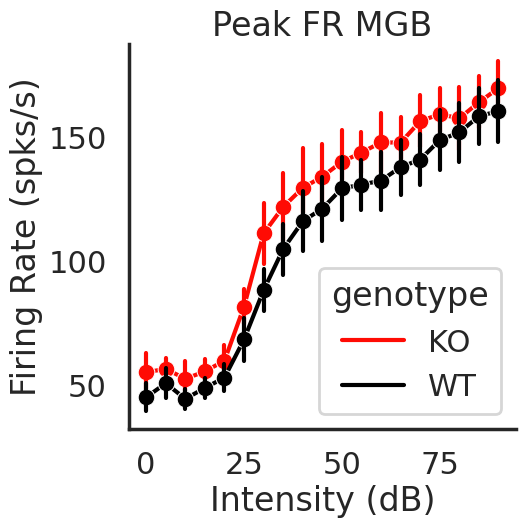

In [84]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='abs_peak_fr',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#sns.catplot(data=test_g,x='intensity',y='latency',hue='genotype')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spks/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak FR MGB')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_fr_MGB.svg',dpi=600,bbox_inches='tight')


/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

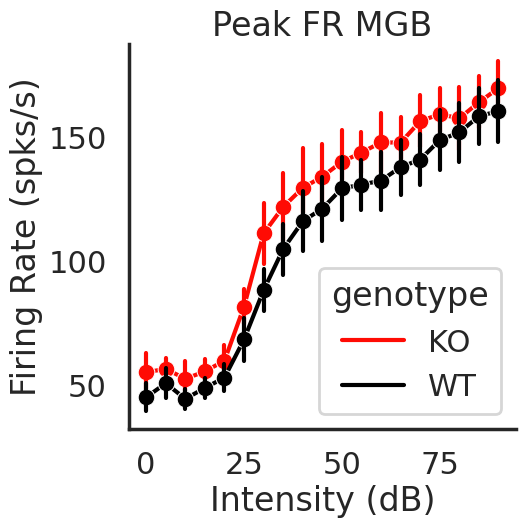

In [85]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='abs_peak_fr',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#sns.catplot(data=test_g,x='intensity',y='latency',hue='genotype')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spks/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak FR MGB')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_fr_MGB.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

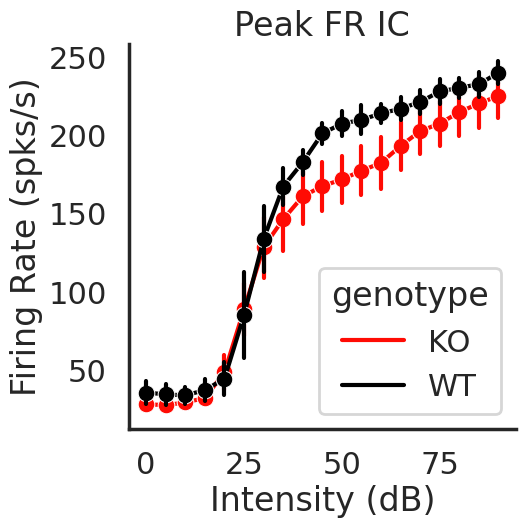

In [87]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='abs_peak_fr',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#sns.catplot(data=test_g,x='intensity',y='latency',hue='genotype')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spks/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak FR IC')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_fr_IC.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

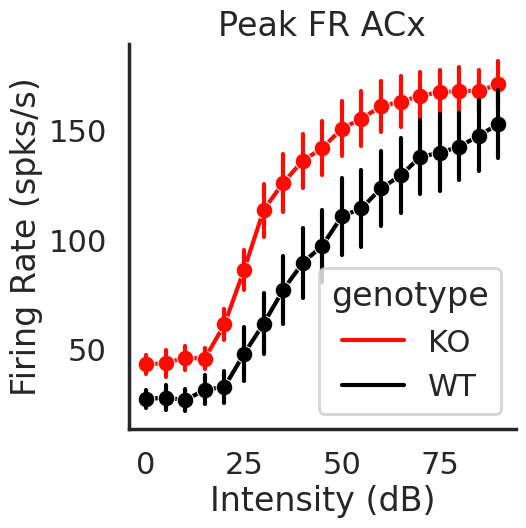

In [88]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ac_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='abs_peak_fr',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#sns.catplot(data=test_g,x='intensity',y='latency',hue='genotype')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spks/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak FR ACx')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_fr_ACx.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

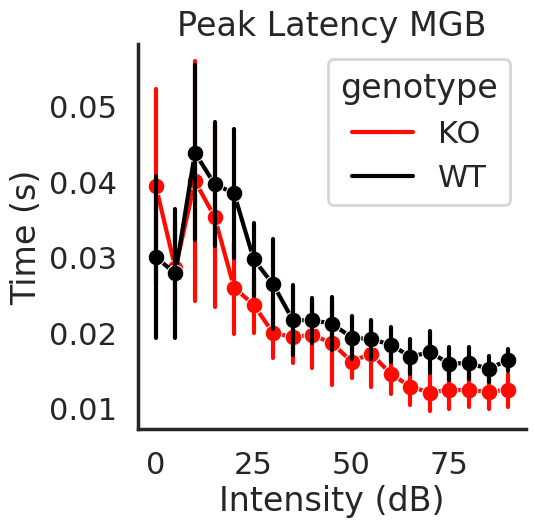

In [68]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='latency',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#sns.catplot(data=test_g,x='intensity',y='latency',hue='genotype')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak Latency MGB')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_altency_MGB.svg',dpi=600,bbox_inches='tight')


/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

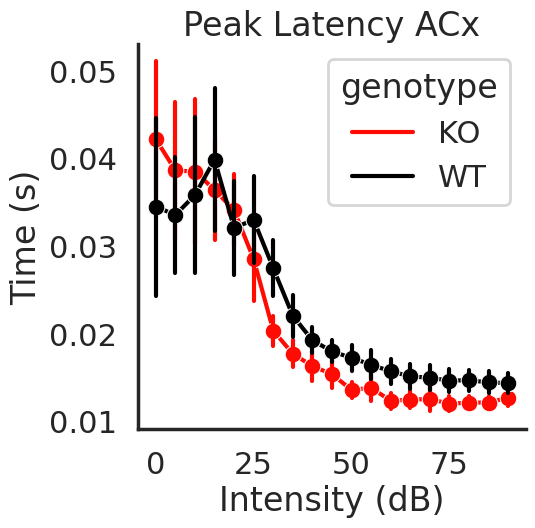

In [69]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ac_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='latency',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak Latency ACx')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_latency_ACx.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

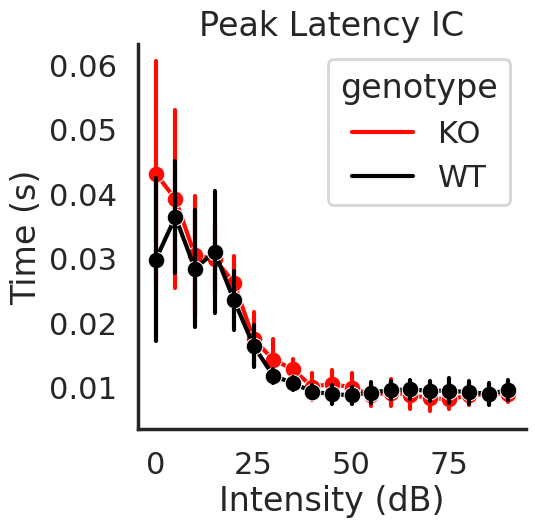

In [70]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='latency',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])

'''lines = ax1.get_lines()
marker_size = 9  # Adjust this value as needed
plt.setp(lines, markersize=marker_size)'''
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Peak Latency IC')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('peak_latency_IC.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

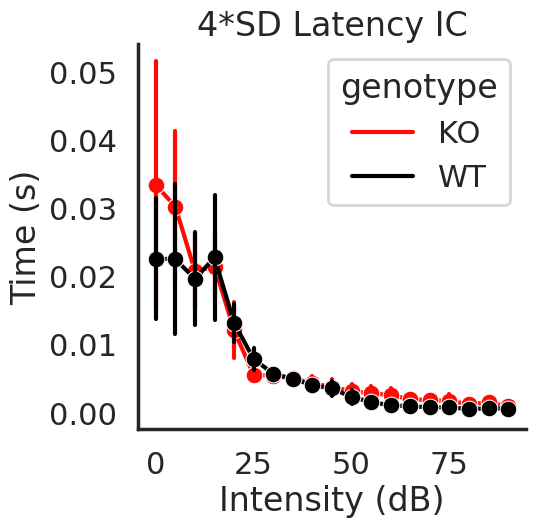

In [71]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='first_bin',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('4*SD Latency IC')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('sd4_latency_IC.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

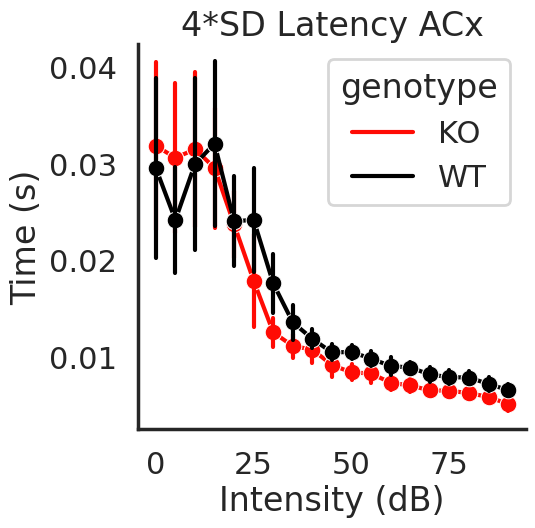

In [72]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ac_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='first_bin',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('4*SD Latency ACx')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('sd4_latency_ACx.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

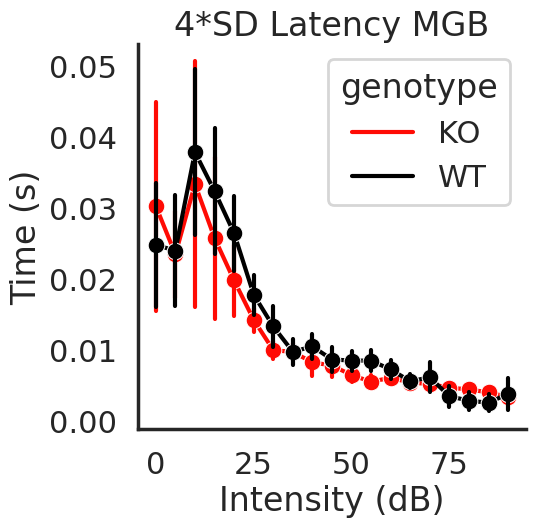

In [73]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='first_bin',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('4*SD Latency MGB')
sns.despine()
#plt.legend([],[], frameon=False)
#plt.xlim([20,90])
#plt.ylim([0,0.03])
#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('sd4_latency_MGB.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

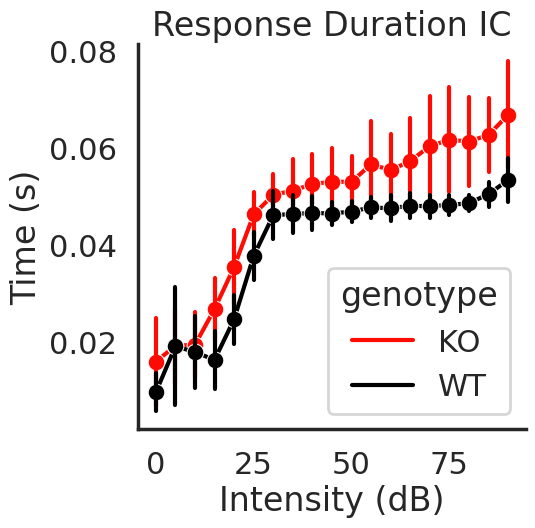

In [74]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='resp_duration',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Response Duration IC')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('duration_rlf_IC.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

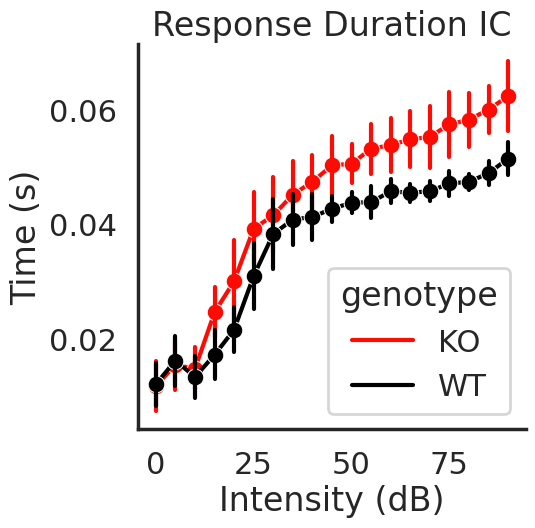

In [9]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='resp_duration',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Response Duration IC')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('duration_rlf_IC_redo.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

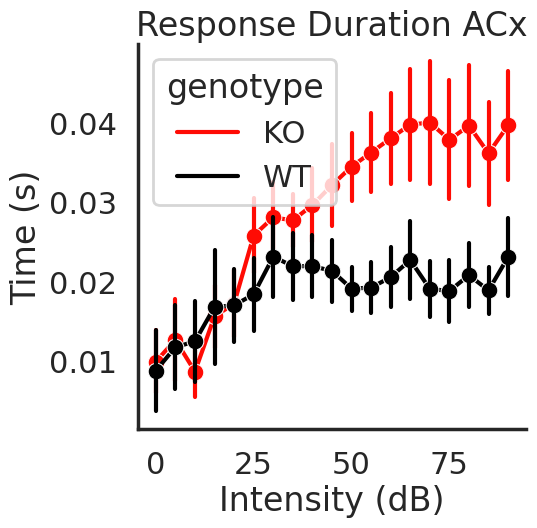

In [75]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ac_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='resp_duration',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Response Duration ACx')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('duration_rlf_ACx.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

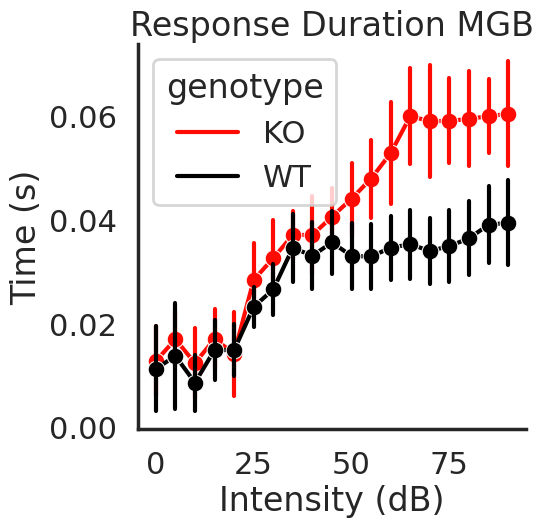

In [76]:
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
sns.lineplot(data=test_g,x='intensity',y='resp_duration',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('Response Duration MGB')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('duration_rlf_MGB.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

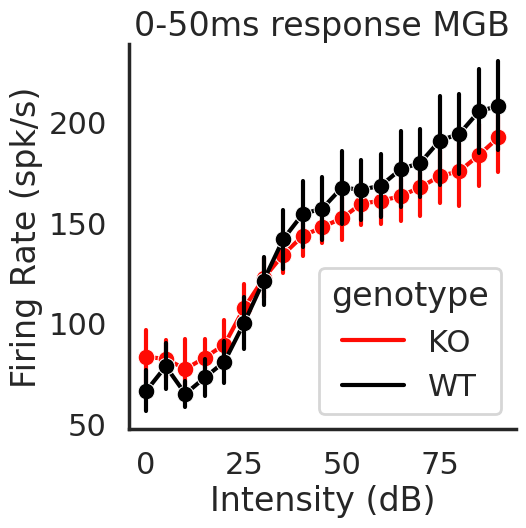

In [83]:
# look at firing from 0 to 50 ms
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = mgb_db.groupby(['file','intensity','genotype']).mean()
test_g['spks_10_40ms'] = test_g['spks_10_40ms'] / 5
sns.lineplot(data=test_g,x='intensity',y='spks_10_40ms',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spk/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('0-50ms response MGB')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('full_stim_firing_MGB.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

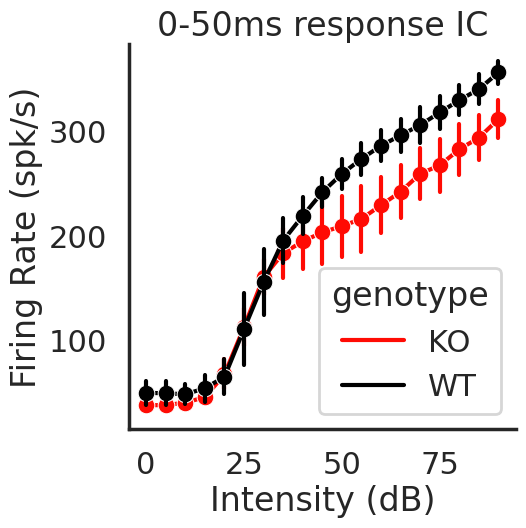

In [82]:
# look at firing from 0 to 50 ms
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ic_db.groupby(['file','intensity','genotype']).mean()
test_g['spks_10_40ms'] = test_g['spks_10_40ms'] / 5
sns.lineplot(data=test_g,x='intensity',y='spks_10_40ms',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spk/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('0-50ms response IC')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('full_stim_firing_IC.svg',dpi=600,bbox_inches='tight')



/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/auerbach1/anaconda3/envs/spikeinterface_testing/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/auerbach1/anaconda3/envs/spik

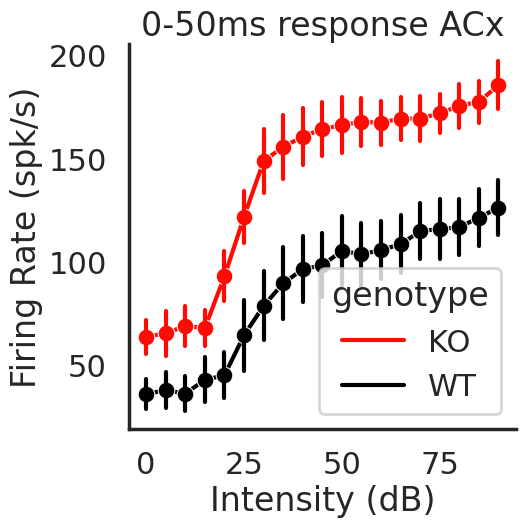

In [81]:
# look at firing from 0 to 50 ms
# plot each column as an average then as a function of intensity
sns.set_theme(context = 'poster',style='white')
colors = ["#FF0B04" ,"#000000"]
sns.set_palette(sns.color_palette(colors))
fig1,ax1 = plt.subplots(figsize=(5,5))
test_g = ac_db.groupby(['file','intensity','genotype']).mean()
test_g['spks_10_40ms'] = test_g['spks_10_40ms'] / 5
sns.lineplot(data=test_g,x='intensity',y='spks_10_40ms',hue='genotype',marker='o',errorbar=('se',2),ax=ax1,err_style='bars')
#ax1.set_xticklabels(['0','1/3','2/3','1'])
ax1.set_ylabel('Firing Rate (spk/s)')
ax1.set_xlabel('Intensity (dB)')
ax1.set_title('0-50ms response ACx')
sns.despine()
#plt.legend([],[], frameon=False)

#plt.savefig('C:/Users/admin/Box/Behavior Lab/Shared/Walker/fmr1_SD_analysis/final_figure_processing/ic_distance_cf_norm.svg',bbox_inches='tight')
plt.savefig('full_stim_firing_ACx.svg',dpi=600,bbox_inches='tight')



In [5]:
# grand PSTH?

mgb_db['PSTH'][19]

0    41.2
dtype: float64

In [6]:
mgb_db

latency  abs_peak_fr  rel_peak_fr  resp_duration  first_bin  last_bin  \
19   -0.044971         62.0    45.000363          0.005 -10.000000  0.020000   
20    0.040193         77.0    60.339260          0.000   0.040193  0.040193   
21    0.010152         67.0    50.877016          0.005   0.010152  0.015152   
22    0.025029         57.0    42.909464          0.000   0.025029  0.025029   
23    0.030029         74.0    59.287949          0.030   0.015029  0.060029   
...        ...          ...          ...            ...        ...       ...   
7424  0.010111        165.0   150.355235          0.005   0.005111  0.015111   
7425  0.010111        158.0   146.120980          0.085   0.005111  0.095111   
7426  0.010193        154.0   140.054781          0.010   0.005193  0.020193   
7427  0.010070        154.0   142.138661          0.020   0.005070  0.030070   
7428  0.010029        167.0   153.796933          0.010 -10.000000  0.020029   

      smoothed_data  spks_10_40ms  \
19        45.000363         382.0   
20        60.339260         533.0   
21        50.877016         532.0   
22        42.909464         466.0   
23        59.287949         623.0   
...             ...           ...   
7424     150.355235         595.0   
7425     146.120980         592.0   
7426     140.054781         649.0   
7427     142.138661         693.0   
7428     153.796933         750.0   

                                                   file channel genotype  \
19    /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      17       WT   
20    /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      17       WT   
21    /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      17       WT   
22    /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      17       WT   
23    /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      17       WT   
...                                                 ...     ...      ...   
7424  /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      32       KO   
7425  /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      32       KO   
7426  /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      32       KO   
7427  /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      32       KO   
7428  /media/auerbach1/Auerbach_HD_WG/Fmr1 SD Tanks/...      32       KO   

                               PSTH  intensity  
19         0    41.2
dtype: float64          0  
20    0    52.466667
dtype: float64          5  
21    0    48.766667
dtype: float64         10  
22    0    43.666667
dtype: float64         15  
23         0    52.0
dtype: float64         20  
...                             ...        ...  
7424  0    41.133333
dtype: float64         70  
7425  0    40.966667
dtype: float64         75  
7426       0    43.7
dtype: float64         80  
7427  0    42.766667
dtype: float64         85  
7428       0    49.6
dtype: float64         90  

[6555 rows x 13 columns]